# 04 - Full waveform inversion with Devito, SciPy and Dask

## Introduction

In this tutorial we show how [Devito](http://www.opesci.org/devito-public) can be used with [Dask](https://dask.pydata.org/en/latest/#dask) to perform [fullwave form inversion](https://www.slim.eos.ubc.ca/research/inversion) (FWI). In this case we know the real solution and we are creating our synthetic 'observed' data on the fly rather than reading the data in from a file as we would in a real probem. However, the inversion workflow is representive of the real case.

## What is Dask?

> [Dask](https://dask.pydata.org/en/latest/#dask) is a flexible parallel computing library for analytic computing.
>
> Dask is composed of two components:
>
> * Dynamic task scheduling optimized for computation... This is similar to Airflow, Luigi, Celery, or Make, but optimized for interactive computational workloads.
> * “Big Data” collections like parallel arrays, dataframes, and lists that extend common interfaces like NumPy, Pandas, or Python iterators to larger-than-memory or distributed environments. These parallel collections run on top of the dynamic task schedulers.
> Dask emphasizes the following virtues:
> 
> * Familiar: Provides parallelized NumPy array and Pandas DataFrame objects
> * Flexible: Provides a task scheduling interface for more custom workloads and integration with other projects.
> * Native: Enables distributed computing in Pure Python with access to the PyData stack.
> * Fast: Operates with low overhead, low latency, and minimal serialization necessary for fast numerical algorithms
> * Scales up: Runs resiliently on clusters with 1000s of cores
> * Scales down: Trivial to set up and run on a laptop in a single process
> * Responsive: Designed with interactive computing in mind it provides rapid feedback and diagnostics to aid humans

## Setting up (synthetic) data
In a real world scenario we work with collected seismic data; for the tutorial we know what the actual solution is and we are using the workers to also generate the synthetic data on the fly.

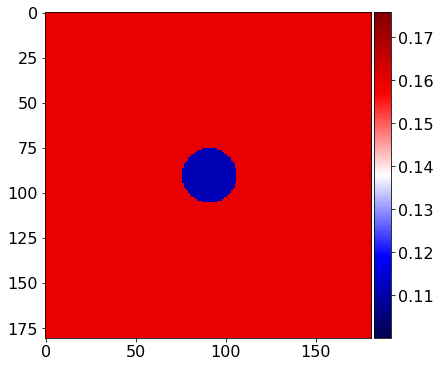

In [1]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import Model, demo_model

# Define the grid parameters
def get_grid():
    shape = (101, 101)    # Number of grid point (nx, nz)
    spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
    origin = (0., 0.)     # Need origin to define relative source and receiver locations

    return shape, spacing, origin

# Define the test phantom; in this case we are using a simple circle
# so we can easily see what is going on.
def get_true_model():
    shape, spacing, origin = get_grid()
    return demo_model('circle-isotropic', vp=3.0, vp_background=2.5, 
                      origin=origin, shape=shape, spacing=spacing, nbpml=40)

# Import convenience function for plotting results
from examples.seismic import plot_image

plot_image(get_true_model().m.data, cmap="seismic")

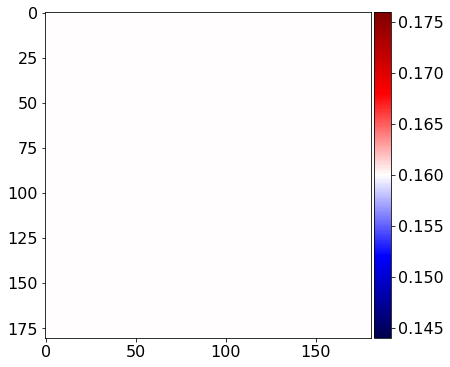

In [2]:
#NBVAL_IGNORE_OUTPUT

# The initial guess for the subsurface model.
def get_initial_model():
    shape, spacing, origin = get_grid()

    return demo_model('circle-isotropic', vp=2.5, vp_background=2.5, 
                      origin=origin, shape=shape, spacing=spacing, nbpml=40)

plot_image(get_initial_model().m.data, cmap="seismic")

In [3]:
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import RickerSource, Receiver

# This is used by the worker to get the current model. 
def get_current_model(param):
    """ Returns the current model.
    """
    model = get_initial_model()
    model.m.data[:] = np.reshape(np.load(param['model']), model.m.data.shape)
    return model

# Inversion crime alert! Here the worker is creating the 'observed' data
# using the real model. For a real case the worker would be reading
# seismic data from disk.
def get_data(param):
    """ Returns source and receiver data for a single shot labeled 'shot_id'.
    """
    true_model = get_true_model()
    dt = true_model.critical_dt  # Time step from model grid spacing

    # Set up source data and geometry.
    nt = int(1 + (param['tn']-param['t0']) / dt)  # Discrete time axis length

    src = RickerSource(name='src', ndim=2, f0=param['f0'],
                       time=np.linspace(param['t0'], param['tn'], nt))
    src.coordinates.data[0, :] = [30, param['shot_id']*1000./(param['nshots']-1)]

    # Set up receiver data and geometry.
    nreceivers = 101  # Number of receiver locations per shot
    rec = Receiver(name='rec', npoint=nreceivers, ntime=nt, ndim=2)
    rec.coordinates.data[:, 1] = np.linspace(0, true_model.domain_size[0], num=nreceivers)
    rec.coordinates.data[:, 0] = 980. # 20m from the right end

    # Set up solver - using model_in so that we have the same dt,
    # otherwise we should use pandas to resample the time series data. 
    solver = AcousticWaveSolver(true_model, src, rec, space_order=4)

    # Generate synthetic receiver data from true model
    true_d, _, _ = solver.forward(src=src, m=true_model.m)

    return src, true_d, nt, solver

## Create operators for gradient based inversion
To perform the inversion we are going to use [scipy.optimize.minimize(method=’L-BFGS-B’)](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html#optimize-minimize-lbfgsb)
```python
scipy.optimize.minimize(fun, x0, args=(), method='L-BFGS-B', jac=None, bounds=None, tol=None, callback=None, options={'disp': None, 'maxls': 20, 'iprint': -1, 'gtol': 1e-05, 'eps': 1e-08, 'maxiter': 15000, 'ftol': 2.220446049250313e-09, 'maxcor': 10, 'maxfun': 15000})```

The argument `fun` is a callable function that returns the misfit between the modelled and the observed data. If `jac` is a Boolean and is `True`, `fun` is assumed to return the gradient along with the objective function - this is convenient when applying the adjoint-method as the mismatch and gradient are calculated together.

So lets build up the various components that we will need. First off we define a type to store the functional and gradient. The main reason for defining this as its own type is so that we can define `__add__` and pass lists of this type into `sum`.

In [4]:
# Type to store functional (f) and gradient (g) pairs used in optimisation.
class fg_pair:
    def __init__(self, f, g):
        self.f = f
        self.g = g
    
    def __add__(self, other):
        f = self.f + other.f
        g = self.g + other.g
        
        return fg_pair(f, g)
    
    def __radd__(self, other):
        if other == 0:
            return self
        else:
            return self.__add__(other)

Next we define the functional and gradient operator (i.e. the function ```fun``` above) for a single shot of data. This is the work that is going to get mapped to the worker pool. The results have to be summed (may need to think about a tree reduction for large data set) over all shots to form the final functional and gradient used to form the inversion update.

In [5]:
from devito import Function, clear_cache

# Create FWI gradient kernel for a single shot
def fwi_gradient_i(param):
    # Need to clear the workers cache.
    clear_cache()

    # Load the current model and the shot data for this worker.
    model0 = get_current_model(param)
    src, rec, nt, solver = get_data(param)
    
    # Create symbols to hold the gradient and the mismatch between
    # the 'measured' and simulated data.
    grad = Function(name="grad", grid=model0.grid)
    residual = Receiver(name='rec', ntime=nt, coordinates=rec.coordinates.data)
    
    # Compute simulated data and full forward wavefield u0
    d, u0, _ = solver.forward(src=src, m=model0.m, save=True)
        
    # Compute the data mismatch (residual) and objective function  
    residual.data[:] = d.data[:] - rec.data[:]
    f = .5*np.linalg.norm(residual.data.flatten())**2
    
    # Compute gradient using the adjoint-state method. Note, this
    # backpropogates the data mismatch through the model.
    solver.gradient(rec=residual, u=u0, m=model0.m, grad=grad)
    
    # Dask got-ya: Take a copy of the gradient as it appears that
    # Dask asynchronous communication can result in the solution
    # being erased (via clear_cache) before reduction is performed.
    g = np.array(grad.data[:])
    
    # If this was an marine seismic inversion for example then we
    # we could zero the gradient in regions where the solution was
    # known (i.e. we know the acoustic velocity in sea water, we don't
    # want the optimization loop changing it.)
    g[0:25,  :] = 0.
    g[-25:,:] = 0.

    # return the objective functional and gradient.
    return fg_pair(f, g)

Define the global functional-gradient operator. This does the following:
* Creates the Dask cluster
* Maps the worklist (shots) to the cluster so that the invidual contributions to (f, g) are computed.
* Sum individual contributions to (f, g) and returns the result.

In [6]:
import numpy as np
from distributed import Client

# Dumps the model to disk; workers will pick this up when they need it.
# Dask is not really designed for broadcasting large volumes of data.
def dump_model(param, model):
    np.save(param['model'], model.astype(np.float32))

    
def fwi_gradient(model, param):
    # Dump a copy of the current model for the workers
    # to pick up when they are ready.
    param['model'] = "model_0.npy"
    dump_model(param, model)

    # Define work list
    work = [dict(param) for i in range(param['nshots'])]
    for i in  range(param['nshots']):
        work[i]['shot_id'] = i
        
    # Start dask cluster
    client = Client()
    
    # Map worklist to cluster
    fgi = client.map(fwi_gradient_i, work)
    
    # Perform reduction on cluster
    fg = client.submit(sum, fgi).result()
    
    # Shutdown cluster
    client.close()
    
    # L-BFGS in scipy expects a flat array in 64-bit floats.
    return fg.f, fg.g.flatten().astype(np.float64)

## FWI with L-BFGS-B
Equipped with a function to calculate the functional and gradient, we are finally ready to define the optimization function.

In [7]:
from scipy import optimize

def fwi(model, param, ftol):
    # Define solution bounds so we stop inversion generating unphysical results.
    box_constraints = tuple((param['m_bounds'][0], param['m_bounds'][1])
                            for i in range(model.m.data.size))
    
    result = optimize.minimize(fwi_gradient,
                               model.m.data.flatten().astype(np.float64),
                               args=(param, ), method='L-BFGS-B', jac=True,
                               bounds=box_constraints,
                               options={'ftol': ftol, 'maxiter': 100, 'disp': True})

    return result

      fun: 152.49635216691991
 hess_inv: <32761x32761 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0.,  0., ...,  0.,  0.,  0.])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 10
      nit: 6
   status: 0
  success: True
        x: array([ 0.16,  0.16,  0.16, ...,  0.16,  0.16,  0.16])


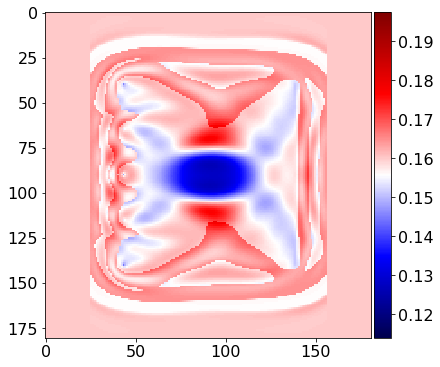

In [8]:
#NBVAL_SKIP

# Set up inversion parameters.
param = {'t0': 0.,
         'tn': 1000.,              # Simulation last 1 second (1000 ms)
         'f0': 0.010,              # Source peak frequency is 10Hz (0.010 kHz)
         'nshots': 5,              # Number of shots to create gradient from
         'm_bounds': (0.08, 0.25)} # Set the min and max slowness

model0 = get_initial_model()

# Baby steps
result = fwi(model0, param, ftol=0.5)

# Print out results of optimizer.
print(result)

# Show what the update does to the model
plot_image(result.x.reshape(181, 181), cmap="seismic")

## Total variation minimization 
There is a lot of research on regularisation to improve the quality of the final result beyond the simple box constraints implemented above. One example is [total variation denoising]( https://en.wikipedia.org/wiki/Total_variation_denoising); and different strategies have been explored applying this as [constraints or as penalties](https://doi.org/10.1190/tle36010094.1).

As shown below, it is relatively straightforward to integrate this with [scikit-image](http://scikit-image.org/) to create more complex image processing pipelines.

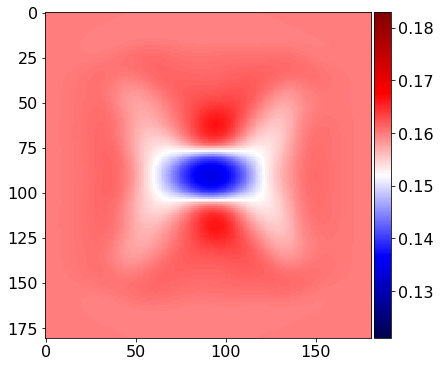

In [9]:
#NBVAL_SKIP
from skimage.restoration import denoise_tv_chambolle as denoise

denoised_image = denoise(result.x.reshape(181, 181))
plot_image(denoised_image, cmap="seismic")

      fun: 0.75780991048487323
 hess_inv: <32761x32761 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0.,  0., ...,  0.,  0.,  0.])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 101
      nit: 92
   status: 0
  success: True
        x: array([ 0.15999998,  0.15999997,  0.15999994, ...,  0.16000025,
        0.16000026,  0.16000026])


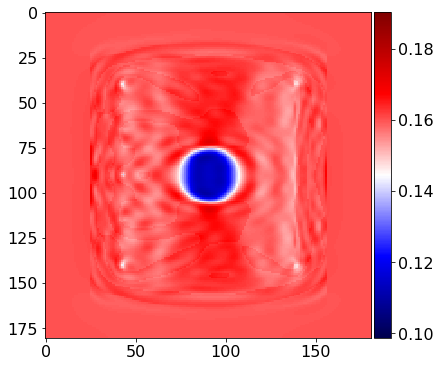

In [10]:
#NBVAL_SKIP

# Solve again with a tighter tolerance;
# but be warned, it can start taking a lot longer to compute.
model0.m.data[:] = denoised_image
result = fwi(model0, param, ftol=0.01)
print(result)

# Show the updated model
plot_image(result.x.reshape(181, 181), cmap="seismic")

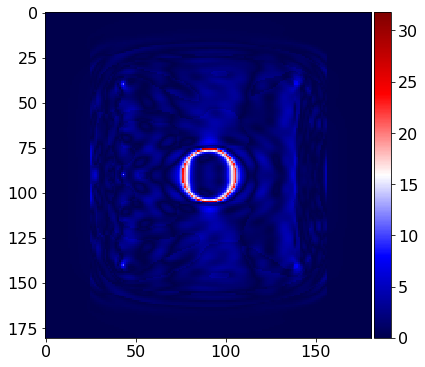

In [11]:
#NBVAL_SKIP

# Plot percentage error
error = np.abs(result.x.reshape(181, 181)-get_true_model().m.data)/get_true_model().m.data
plot_image(100*error, cmap="seismic")

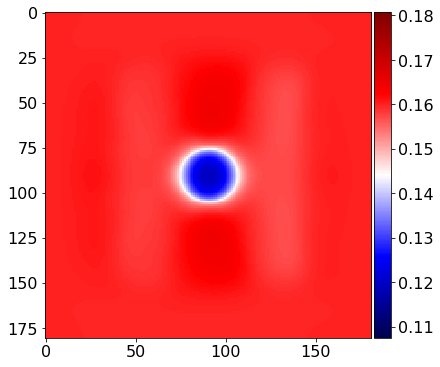

In [12]:
#NBVAL_SKIP

# Apply TV denosing again.
denoised_image = denoise(result.x.reshape(181, 181))
plot_image(denoised_image, cmap="seismic")

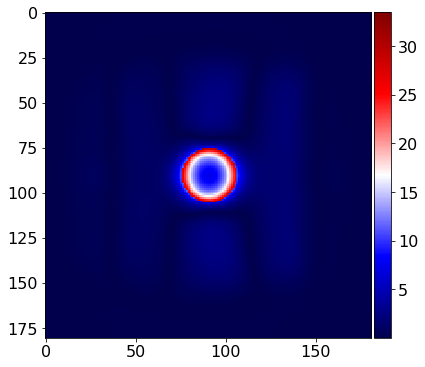

In [13]:
#NBVAL_SKIP

# Plot percentage error after denoising
error = np.abs(denoised_image-get_true_model().m.data)/get_true_model().m.data
plot_image(100*error, cmap="seismic")